Grid Search

Libraries

In [16]:
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Libraries
import matplotlib.pyplot as plt

Preprocessing

In [17]:
# Preprocessing function
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Canny edge detection
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    edges = cv2.Canny(image, 100, 200)
    img = Image.fromarray(edges)
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

# Load preprocessed images
train_dir = 'processed_images'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)    

KeyboardInterrupt: 

Model Creation

In [18]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [22]:
class KerasClassifierGen(KerasClassifier):
    def fit(self, x, y, **kwargs):
        return self.model.fit(x, y, **kwargs)
    
    def fit_generator(self, generator, steps_per_epoch, **kwargs):
        return self.model.fit(generator, steps_per_epoch=steps_per_epoch, **kwargs)
    
    def score(self, x, y, **kwargs):
        return self.model.evaluate(x, y, **kwargs)[1]

#create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# parameters
param_grid = {
    'optimizer': ['SGD', 'Adam'],
    'model__init_mode': ['uniform', 'he_normal'],
    'epochs': [10, 20],
    'batch_size': [10, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# steps_per_epoch = len(train_generator)
# grid_result = grid.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10)


# Get a subset of the data
X_train, y_train = next(train_generator)
X_val, y_val = next(test_generator)

# Using a smaller subset to avoid memory issues
# X_train, y_train = next(train_generator)
# for _ in range(5):  # Adjust the range to control the subset size
#     X, y = next(train_generator)
#     X_train = np.vstack((X_train, X))
#     y_train = np.vstack((y_train, y))


# Fit the grid search
grid_result = grid.fit(X_train, y_train)

/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_con

In [8]:
# Retrieve best Keras Classfiier
best_params = grid_result.best_params_
best_model = create_model(optimizer=best_params['optimizer'], init_mode=best_params['model__init_mode'])

history = best_model.fit(
    train_generator,
    epochs=grid_result.best_params_['epochs'],
    validation_data=test_generator,
    batch_size=grid_result.best_params_['batch_size']
)

/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 2485s 8s/step - accuracy: 0.0608 - loss: 3.0282 - val_accuracy: 0.0438 - val_loss: 4.4638
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 214s 641ms/step - accuracy: 0.1099 - loss: 2.8327 - val_accuracy: 0.0524 - val_loss: 5.7812
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 187s 562ms/step - accuracy: 0.1266 - loss: 2.7618 - val_accuracy: 0.0514 - val_loss: 6.8383
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 294s 888ms/step - accuracy: 0.1451 - loss: 2.6923 - val_accuracy: 0.0524 - val_loss: 6.9614
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 93s 276ms/step - accuracy: 0.1455 - loss: 2.6689 - val_accuracy: 0.0486 - val_loss: 9.0034
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 96s 285ms/step - accuracy: 0.1598 - loss: 2.6230 - val_accuracy: 0.0514 - val_loss: 9.3746
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 96s 287ms/step - accuracy: 0.1666 - loss: 2.6155 - val_accuracy: 0.0495 - val_loss: 7.9676
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 92s 276ms/step - accuracy: 0.1699 - loss: 2.5809 - v

Plotting

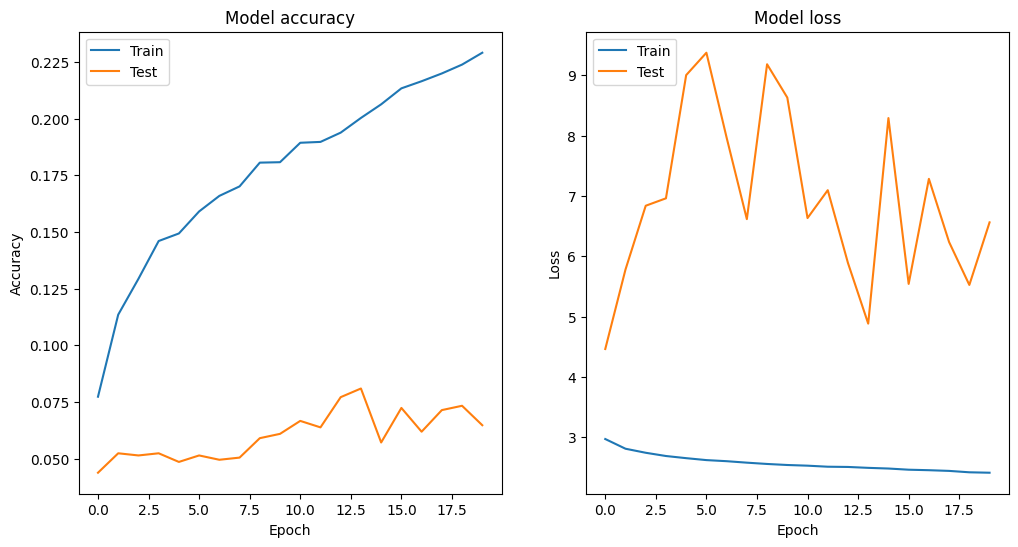

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
# Summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")